## Visualize the signature application to other clone data

In `9.apply-signature-otherclones.ipynb`, I acquired bortezomib resistance signature scores.
Here, I visualize them.

**Yu Han, 2021**

Modified Greg's original 11.0 script to visulize the new results generated with the new batch dataset. Commented out all lines associated with 'split'. 

In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(cowplot))
suppressPackageStartupMessages(library(gridExtra))

source(file.path("utils", "viz.R"))

In [2]:
seed <- 1234
set.seed(seed)

In [3]:
# Set constants
dataset <- "otherclones"
sig_dir <- file.path("results", "singscore")
perf_dir <- file.path("results", "performance")

sig_results_file <- file.path(sig_dir, paste0("singscore_results_LAST_BATCH_VALIDATIONotherclones.tsv.gz"))
roc_auc_file <- file.path(perf_dir, paste0(dataset, "_bortezomibsignature_roc_auc_LAST_BATCH_VALIDATION.tsv"))
roc_curve_file <- file.path(perf_dir, paste0(dataset, "_bortezomibsignature_roc_curve_LAST_BATCH_VALIDATION.tsv"))

output_figure_dir <- file.path("figures", "singscore")

In [4]:
# Load signature scores
# Load raw signature results
sig_cols <- readr::cols(
    .default = readr::col_character(),
    Metadata_clone_type_indicator = readr::col_integer(),
    Metadata_celltype_shorthand_from_plate_graph = readr::col_integer(),
    Metadata_date = readr::col_integer(),
    Metadata_treatment_shorthand_from_plate_graph = readr::col_integer(),
    TotalScore = readr::col_double(),
    TotalDispersion = readr::col_double(),
    UpScore = readr::col_double(),
    UpDispersion = readr::col_double(),
    DownScore = readr::col_double(),
    DownDispersion = readr::col_double(),
    Metadata_permuted_p_value = readr::col_double(),
    min_permuted_value = readr::col_double(),
    max_permuted_value = readr::col_double()
)

signature_df <- readr::read_tsv(sig_results_file, col_types = sig_cols) 

print(dim(signature_df))
head(signature_df, 4)

# A tibble: 800 x 28
   Metadata_Plate Metadata_Well Metadata_batch Metadata_cell_c… Metadata_cell_d…
   <chr>          <chr>         <chr>          <chr>            <chr>           
 1 221057         B02           2021_08_02_Ba… 4574             2.5x10^3 cells/…
 2 221057         B03           2021_08_02_Ba… 3444             2.5x10^3 cells/…
 3 221057         B04           2021_08_02_Ba… 3725             2.5x10^3 cells/…
 4 221057         B05           2021_08_02_Ba… 1814             2.5x10^3 cells/…
 5 221057         B06           2021_08_02_Ba… 5481             2.5x10^3 cells/…
 6 221057         B07           2021_08_02_Ba… 3692             2.5x10^3 cells/…
 7 221057         B08           2021_08_02_Ba… 2971             2.5x10^3 cells/…
 8 221057         B09           2021_08_02_Ba… 4027             2.5x10^3 cells/…
 9 221057         B10           2021_08_02_Ba… 1925             2.5x10^3 cells/…
10 221057         B11           2021_08_02_Ba… 3910             2.5x10^3 cells/…
# … wit

Metadata_Plate,Metadata_Well,Metadata_batch,Metadata_cell_count,Metadata_cell_density,Metadata_celltype_shorthand_from_plate_graph,Metadata_clone_number,Metadata_date,Metadata_plate_map_name,Metadata_time_to_adhere,⋯,TotalScore,TotalDispersion,UpScore,UpDispersion,DownScore,DownDispersion,Metadata_permuted_p_value,dataset,min_permuted_value,max_permuted_value
<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<int>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>
221057,B02,2021_08_02_Batch24,4574,2.5x10^3 cells/well,1,WT_parental,20210728,221057,48 hr,⋯,-0.5764640,215.7183,-0.34505208,79.3191,-0.2314119,136.3992,1.000,otherclones,-0.1563059,0.1566529
221057,B03,2021_08_02_Batch24,3444,2.5x10^3 cells/well,2,CloneA,20210728,221057,48 hr,⋯,0.2382755,480.3624,0.09161086,210.5292,0.1466647,269.8332,0.005,otherclones,-0.1563059,0.1566529
221057,B04,2021_08_02_Batch24,3725,2.5x10^3 cells/well,3,CloneE,20210728,221057,48 hr,⋯,0.2617121,332.8437,0.09421503,166.7925,0.1674971,166.0512,0.003,otherclones,-0.1563059,0.1566529
221057,B05,2021_08_02_Batch24,1814,2.5x10^3 cells/well,4,WT clone 10,20210728,221057,48 hr,⋯,0.2996256,446.2626,0.21670387,170.4990,0.0829217,275.7636,0.001,otherclones,-0.1563059,0.1566529


In [5]:
# Load performance metrics info
metric_levels <- c("dataset")
shuffle_levels <- c("", "shuffle")

performance_data <- list()
for (metric_level in metric_levels) {
    performance_data[[metric_level]] <- list()
    for (shuffle_level in shuffle_levels) {
        if (shuffle_level == "shuffle") {
            shuffle_id <- "_shuffle"
        } else {
            shuffle_id <- ""
        }
        
        # Note I set file name here
        input_file <- paste0(metric_level, "_otherclones", shuffle_id, "_metric_performance.tsv")
        input_file <- file.path(perf_dir, input_file)
        
        performance_data[[metric_level]][[shuffle_level]] <-
            readr::read_tsv(input_file, col_types = readr::cols())
    }
}

# Load ROC info
roc_curve_cols <- readr::cols(
    fpr = readr::col_double(),
    tpr = readr::col_double(),
    threshold = readr::col_double(),
    model_split = readr::col_character(),
    shuffled = readr::col_character()
)

roc_curve_df <- readr::read_tsv(roc_curve_file, col_types=roc_curve_cols)

roc_cols <- readr::cols(
    roc_auc = readr::col_double(),
    model_split = readr::col_character(),
    shuffled = readr::col_character()
)

roc_df <- readr::read_tsv(roc_auc_file, col_types=roc_cols) 
    dplyr::arrange(shuffled) %>%
    dplyr::mutate(roc_auc = round(roc_auc, 3))

roc_df <- roc_df[, c("shuffled", "roc_auc")]
colnames(roc_df) <- c("AUROC\nShuffled:", "roc_auc")


Warning message:
“The following named parsers don't match the column names: model_split”Warning message:
“The following named parsers don't match the column names: model_split”

In [6]:
table_theme <- gridExtra::ttheme_default(
    core = list(fg_params=list(cex = 0.3)),
    colhead = list(fg_params=list(cex = 0.3)),
    padding = unit(c(1.5, 1.5), "mm")
)

table_gg <- gridExtra::tableGrob(roc_df,
                                 theme = table_theme,
                                 rows = NULL)

In [7]:
threshold_points_df <- roc_curve_df 
    dplyr::filter(shuffled == "False") 
    dplyr::filter(abs(threshold) == min(abs(threshold))) 
    dplyr::ungroup()

roc_gg <- (
    ggplot(roc_curve_df, aes(x = fpr, y = tpr))
    + geom_line(aes(linetype = shuffled), size=0.2)
    + geom_point(data = threshold_points_df, size = 1)
    + geom_abline(intercept=0, slope=1, size=0.2, linetype="dashed", color="black")
    + scale_color_manual(name="Dataset", labels=legend_labels, values=legend_colors)
    + scale_linetype_manual(name="Shuffled", labels=linetype_labels, values=linetype_default)
    + coord_fixed()
    + xlab("False positive rate")
    + ylab("True positive rate")
    + annotation_custom(table_gg, ymin = -0.82, xmin = 1.6)
    + custom_theme
    + theme(legend.position = "bottom")
    + guides(col = guide_legend(nrow = 2, byrow = TRUE), linetype = guide_legend(nrow = 2, byrow = TRUE))
)

In [8]:
min_val <- unique(signature_df$min_permuted_value)
max_val <- unique(signature_df$max_permuted_value)

In [9]:
box_plot_gg <- (
    ggplot(signature_df, aes(x = Metadata_clone_number, y = TotalScore))
    + geom_boxplot(aes(fill = Metadata_clone_type), lwd = 0.1, alpha = 0.9, outlier.alpha = 0)
    + geom_jitter(
        position = position_jitterdodge(jitter.width = 0.4, dodge.width = 0.75),
        aes(fill = Metadata_clone_type),
        stroke = 0.2,
        alpha = 0.6,
        shape = 21,
        lwd = 0.5
    )
    
    + xlab("")
    + ylab("Signature score\n(singscore)")
    + scale_fill_manual("Resistance status", values = resistance_status_colors, labels = resistance_status_labels)
    + scale_y_continuous(breaks = c(-0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6), minor_breaks = seq(-10, 10, 0.1))
    + geom_hline(yintercept = 0, linetype = "dashed", size = 0.2, color = "black")
    + coord_flip()
    + annotate(
        "rect",
         ymin = min_val,
         ymax = max_val,
         xmin = 0.3,
         xmax = 15,
         alpha = 0.2,
         color = "red",
         linetype = "dashed",
         fill = "grey",
         size = 0.1
    )
    + custom_theme
    + guides(fill = guide_legend(reverse = TRUE))
)

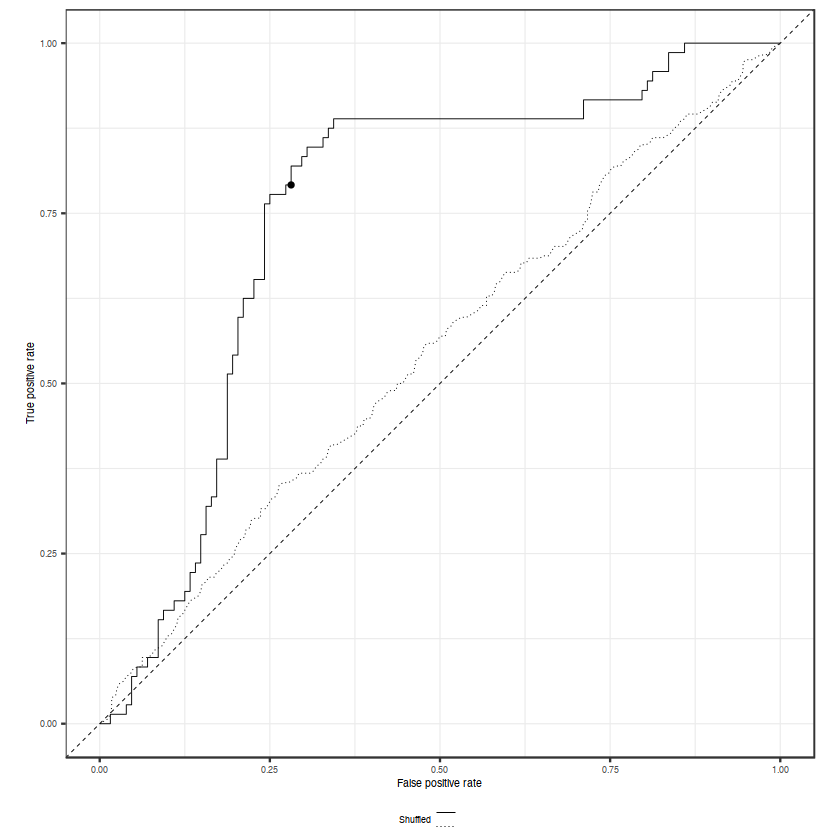

In [10]:
output_fig_file <- file.path("figures", "newbatch_validation_roc.png")
ggsave(output_fig_file, roc_gg, dpi = 500, height = 6, width = 7)

roc_gg

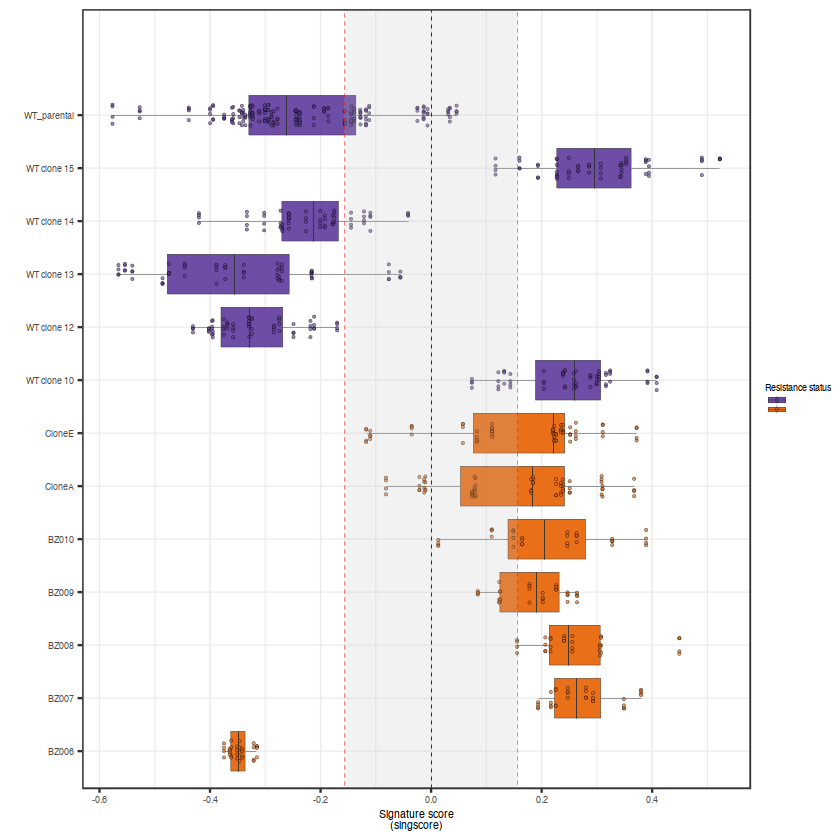

In [11]:
output_fig_file <- file.path("figures", "newbatch_validation_boxplot.png")
ggsave(output_fig_file, box_plot_gg, dpi = 500, height = 6, width = 7)

box_plot_gg